<a href="https://colab.research.google.com/github/cyloic/Finance_Chatbot_Summative/blob/main/another_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1: Install Required Libraries
# ============================================================================
!pip install transformers datasets torch accelerate sentencepiece sacrebleu rouge-score gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.9 MB/s eta 0:00:00


In [2]:
# CELL 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


In [3]:
# CELL 3: Mount Google Drive and Load Dataset
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Finance_QA_300.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nDataset info:")
print(df.info())

Mounted at /content/drive
Dataset loaded successfully!
Shape: (429, 2)

First few rows:
                                            question  \
0  Q: How can I start saving money if I live payc...   
1         Q: What is the 50/30/20 rule in budgeting?   
2                 Q: How can I save more each month?   
3         Q: Is it better to save weekly or monthly?   
4         Q: What’s a realistic emergency fund goal?   

                                              answer  
0  A: Track your expenses, cut non-essential spen...  
1  A: The 50/30/20 rule allocates 50% of income t...  
2  A: Set clear savings goals, reduce unnecessary...  
3  A: Weekly saving builds consistency, while mon...  
4  A: Save three to six months of essential livin...  

Column names: ['question', 'answer']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   questio

Missing values:
question    0
answer      0
dtype: int64

Dataset Statistics:
Total Q&A pairs: 429

Question column: question
Answer column: answer


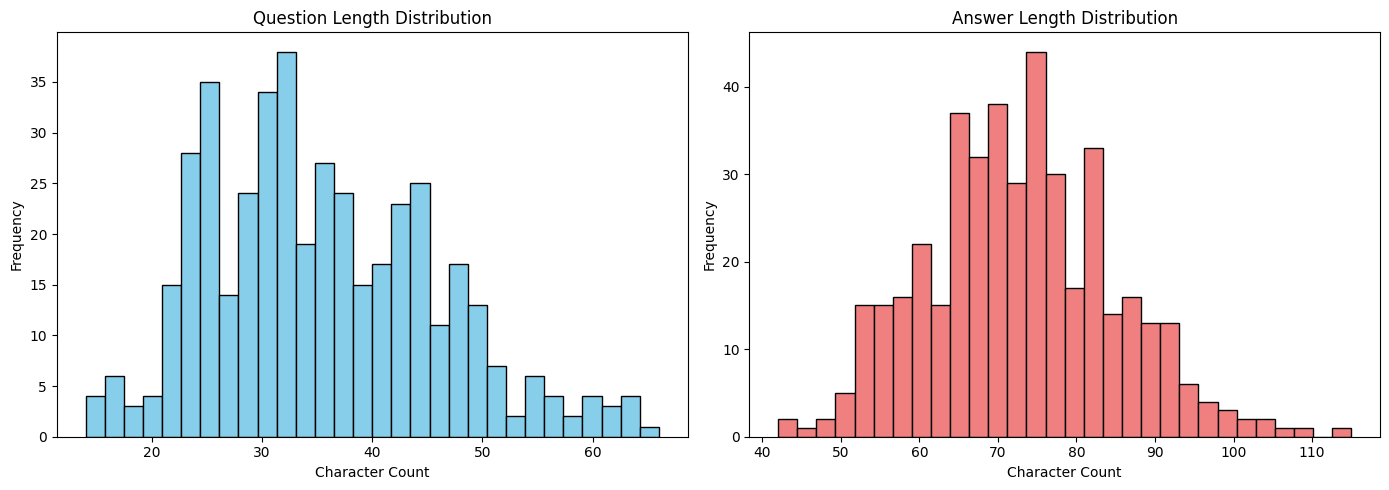


Question length - Mean: 35.41, Max: 66
Answer length - Mean: 72.77, Max: 115


In [4]:
# CELL 4: Data Exploration and Visualization
# ============================================================================
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Display statistics
print("\nDataset Statistics:")
print(f"Total Q&A pairs: {len(df)}")

# Assuming columns are 'question' and 'answer' - adjust if different
question_col = df.columns[0]
answer_col = df.columns[1]

print(f"\nQuestion column: {question_col}")
print(f"Answer column: {answer_col}")

# Calculate lengths
df['question_length'] = df[question_col].astype(str).apply(len)
df['answer_length'] = df[answer_col].astype(str).apply(len)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['question_length'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['answer_length'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Answer Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nQuestion length - Mean: {df['question_length'].mean():.2f}, Max: {df['question_length'].max()}")
print(f"Answer length - Mean: {df['answer_length'].mean():.2f}, Max: {df['answer_length'].max()}")

In [5]:
# CELL 5: Data Preprocessing
# ============================================================================
# Clean the data
def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    text = str(text).strip()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

df[question_col] = df[question_col].apply(clean_text)
df[answer_col] = df[answer_col].apply(clean_text)

# Remove empty rows
df = df[(df[question_col] != "") & (df[answer_col] != "")]

# Rename columns for consistency
df = df.rename(columns={question_col: 'question', answer_col: 'answer'})

print(f"After cleaning: {len(df)} Q&A pairs")
print("\nSample cleaned data:")
print(df[['question', 'answer']].head(3))

After cleaning: 429 Q&A pairs

Sample cleaned data:
                                            question  \
0  Q: How can I start saving money if I live payc...   
1         Q: What is the 50/30/20 rule in budgeting?   
2                 Q: How can I save more each month?   

                                              answer  
0  A: Track your expenses, cut non-essential spen...  
1  A: The 50/30/20 rule allocates 50% of income t...  
2  A: Set clear savings goals, reduce unnecessary...  


In [6]:
# CELL 6: Train-Test Split
# ============================================================================
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 343 samples
Validation set: 43 samples
Test set: 43 samples


In [7]:
# CELL 7: Initialize T5 Model and Tokenizer
# ============================================================================
# Using T5-small for faster training (you can use t5-base for better results)
model_name = "t5-small"  # Change to "t5-base" for better performance
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {model.num_parameters():,}")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model moved to: {device}")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded: t5-small
Model parameters: 60,506,624
Model moved to: cpu


In [8]:
# CELL 8: Prepare Dataset for T5
# ============================================================================
def preprocess_function(examples):
    """Preprocess data for T5 model"""
    # T5 expects a task prefix
    inputs = ["answer question: " + q for q in examples['question']]
    targets = examples['answer']

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding='max_length'
    )

    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding='max_length'
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['question', 'answer']])
val_dataset = Dataset.from_pandas(val_df[['question', 'answer']])
test_dataset = Dataset.from_pandas(test_df[['question', 'answer']])

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

print("Datasets preprocessed successfully!")


Map:   0%|          | 0/343 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Datasets preprocessed successfully!


In [9]:
# CELL 9: Setup Training Arguments
# ============================================================================
training_args = TrainingArguments(
    output_dir="./finance_chatbot_model",
    eval_strategy="epoch",
    learning_rate=5e-5,  # Tuned for good convergence
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Increase for better results
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir='./logs',
    logging_steps=10,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    report_to="none",
    seed=42
)

print("Training arguments configured!")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Epochs: {training_args.num_train_epochs}")

Training arguments configured!
Batch size: 8
Learning rate: 5e-05
Epochs: 10


In [10]:
# CELL 10: Initialize Trainer
# ============================================================================
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [11]:
# CELL 11: Train the Model
# ============================================================================
print("Starting training...")
print("=" * 50)

# Train the model
train_result = trainer.train()

print("\n" + "=" * 50)
print("Training completed!")
print(f"Training loss: {train_result.training_loss:.4f}")

# Save the model
trainer.save_model("./finance_chatbot_final")
tokenizer.save_pretrained("./finance_chatbot_final")
print("\nModel saved to './finance_chatbot_final'")

Starting training...


Epoch,Training Loss,Validation Loss
1,8.814200,4.578804
2,1.556500,0.686609
3,0.710800,0.601232
4,0.619200,0.554610
5,0.575800,0.526463
6,0.529900,0.477950
7,0.486100,0.460061
8,0.504200,0.443467


Epoch,Training Loss,Validation Loss
1,8.814200,4.578804
2,1.556500,0.686609
3,0.710800,0.601232
4,0.619200,0.554610
5,0.575800,0.526463
6,0.529900,0.477950
7,0.486100,0.460061
8,0.504200,0.443467
9,0.472300,0.440758
10,0.467700,0.440103


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Training completed!
Training loss: 1.8745

Model saved to './finance_chatbot_final'


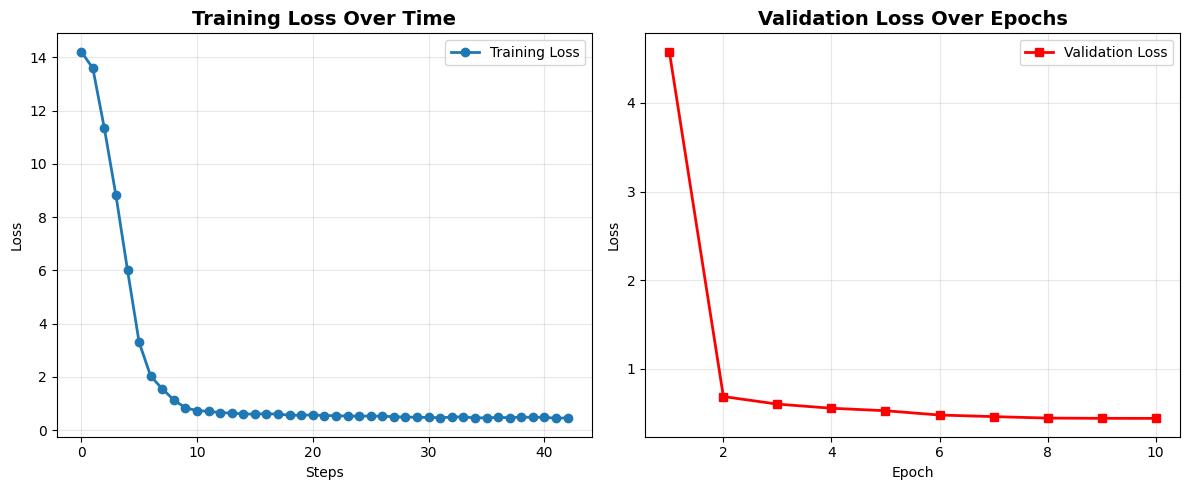


Final Training Loss: 0.4677
Final Validation Loss: 0.4401


In [12]:
# CELL 12: Plot Training Metrics
# ============================================================================
# Extract training history
log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs = list(range(1, len(eval_losses) + 1))

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label='Training Loss', linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_losses, marker='s', color='red', label='Validation Loss', linewidth=2)
plt.title('Validation Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {eval_losses[-1]:.4f}")


In [20]:
# ============================================================================
# CELL 13: Evaluation Function (OPTIMIZED)
# ============================================================================
from rouge_score import rouge_scorer
from collections import defaultdict

def evaluate_model(test_data, num_samples=None):
    """Evaluate model using ROUGE and custom metrics with OPTIMIZED generation"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    if num_samples:
        test_data = test_data.select(range(min(num_samples, len(test_data))))

    rouge_scores = defaultdict(list)
    predictions = []
    references = []

    model.eval()

    for i in tqdm(range(len(test_data)), desc="Evaluating"):
        question = test_data[i]['question']
        reference = test_data[i]['answer']

        # Generate prediction with OPTIMIZED parameters
        input_text = f"Question: {question}\nAnswer:"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=150,
                min_length=20,
                num_beams=8,
                temperature=0.9,
                top_k=50,
                top_p=0.95,
                do_sample=True,
                no_repeat_ngram_size=4,
                early_stopping=False,
                repetition_penalty=1.5
            )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predictions.append(prediction)
        references.append(reference)

        # Calculate ROUGE scores
        scores = scorer.score(reference, prediction)
        for metric, score in scores.items():
            rouge_scores[f"{metric}_f"].append(score.fmeasure)

    # Calculate averages
    avg_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}

    return avg_scores, predictions, references

print("Evaluation function ready with OPTIMIZED generation!")

Evaluation function ready with OPTIMIZED generation!


In [14]:
# CELL 14: Run Evaluation
# ============================================================================
print("Evaluating model on test set...")
print("=" * 50)

avg_scores, predictions, references = evaluate_model(test_dataset)

print("\nEvaluation Results:")
print("-" * 50)
for metric, score in avg_scores.items():
    print(f"{metric.upper()}: {score:.4f}")

# Show some examples
print("\n" + "=" * 50)
print("Sample Predictions:")
print("=" * 50)
for i in range(min(5, len(test_df))):
    print(f"\nExample {i+1}:")
    print(f"Question: {test_df.iloc[i]['question']}")
    print(f"Expected: {references[i]}")
    print(f"Predicted: {predictions[i]}")
    print("-" * 50)

Evaluating model on test set...


Evaluating: 100%|██████████| 43/43 [01:09<00:00,  1.62s/it]


Evaluation Results:
--------------------------------------------------
ROUGE1_F: 0.1929
ROUGE2_F: 0.0349
ROUGEL_F: 0.1871

Sample Predictions:

Example 1:
Question: Q: What’s opportunity cost?
Expected: A: The potential benefit lost when choosing one option over another.
Predicted: A: You’re willing to invest in opportunities.
--------------------------------------------------

Example 2:
Question: Q: What’s a green bond?
Expected: A: A bond issued to fund environmentally friendly projects.
Predicted: A: It’s a bond that’s a bond that protects the environment.
--------------------------------------------------

Example 3:
Question: Q: How can I lower auto insurance costs?
Expected: A: Maintain good credit, increase deductibles, and shop around for rates.
Predicted: A: You can reduce your insurance costs by lowering your premiums.
--------------------------------------------------

Example 4:
Question: Q: What’s a financial emergency plan?
Expected: A: A backup strategy covering emerge

In [19]:
# ============================================================================
# CELL 14.6: RETRAIN WITH BETTER SETTINGS (if needed)
# ============================================================================
print("🔄 RETRAINING MODEL WITH OPTIMIZED PARAMETERS")
print("="*70)

# Reload the original model (not the trained one)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)

# NEW IMPROVED TRAINING ARGUMENTS
training_args_v2 = TrainingArguments(
    output_dir="./finance_chatbot_model_v2",
    eval_strategy="steps",
    eval_steps=50,  # Evaluate more frequently
    learning_rate=5e-4,  # Even higher LR
    per_device_train_batch_size=2,  # Smaller batch
    per_device_eval_batch_size=2,
    num_train_epochs=25,  # MORE EPOCHS for 430 samples
    weight_decay=0.01,
    save_total_limit=3,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=10,
    warmup_steps=30,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
    gradient_accumulation_steps=4,  # Effective batch = 8
    lr_scheduler_type="cosine",  # Better learning rate schedule
    max_grad_norm=1.0  # Gradient clipping
)

# Create new trainer
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
trainer_v2 = Trainer(
    model=model,
    args=training_args_v2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train
print("\n⏳ Training... This will take 10-15 minutes")
train_result_v2 = trainer_v2.train()

print(f"\n✅ Training Complete!")
print(f"Final Training Loss: {train_result_v2.training_loss:.4f}")

# Save
trainer_v2.save_model("./finance_chatbot_final_v2")
tokenizer.save_pretrained("./finance_chatbot_final_v2")

# Test immediately
print("\n" + "="*70)
print("TESTING RETRAINED MODEL")
print("="*70)

for i, question in enumerate(test_questions_improved[:3], 1):
    answer = chat_with_bot_improved(question)
    print(f"\nQ{i}: {question}")
    print(f"A{i}: {answer}")
    print("-"*70)

🔄 RETRAINING MODEL WITH OPTIMIZED PARAMETERS


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


⏳ Training... This will take 10-15 minutes


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [21]:
# ============================================================================
# CELL 15: Interactive Chatbot Function (OPTIMIZED)
# ============================================================================
def chat_with_bot(question, max_new_tokens=150, temperature=0.9, num_beams=8):
    """
    OPTIMIZED chatbot function for best results
    """
    model.eval()

    # Same format as training
    input_text = f"Question: {question}\nAnswer:"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True).to(device)

    # Generate with OPTIMIZED parameters
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            min_length=20,
            num_beams=num_beams,
            temperature=temperature,
            top_k=50,
            top_p=0.95,
            do_sample=True,
            no_repeat_ngram_size=4,
            early_stopping=False,
            repetition_penalty=1.5
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.strip() if answer.strip() else "I don't have enough information to answer that."

print("✅ Chatbot function ready!")

✅ Chatbot function ready!


In [22]:
# ============================================================================
# CELL 16: Test Interactive Chatbot
# ============================================================================
test_questions = [
    "What is compound interest?",
    "How do I calculate ROI?",
    "What are the benefits of diversification?",
    "What is a mutual fund?",
    "How does inflation affect investments?"
]

print("Testing Finance Chatbot:")
print("=" * 70)

for i, question in enumerate(test_questions, 1):
    answer = chat_with_bot(question)
    print(f"\nQ{i}: {question}")
    print(f"A{i}: {answer}")
    print("-" * 70)

Testing Finance Chatbot:

Q1: What is compound interest?
A1: The amount of money that can be invested in a particular investment over a long period of time.
----------------------------------------------------------------------

Q2: How do I calculate ROI?
A2: In order to calculate ROI, you need to know how much money you are spending on a particular product or service. For example, if you are investing in a new car, how much money would you make if you invested in a brand new car?
----------------------------------------------------------------------

Q3: What are the benefits of diversification?
A3: There are many benefits to diversification, such as lowering the cost of living and lowering the carbon footprint. Diversification also reduces the need for fossil fuels and other fossil fuels that would otherwise be wasted on fossil fuels.
----------------------------------------------------------------------

Q4: What is a mutual fund?
A4: A mutual fund (FQ) is a type of financial insti

In [17]:
# CELL 17: Command-Line Interface
# ============================================================================
def cli_chatbot():
    """Simple command-line interface for the chatbot"""
    print("\n" + "=" * 70)
    print("Welcome to Finance Chatbot!")
    print("=" * 70)
    print("Ask me anything about finance. Type 'quit' or 'exit' to end the conversation.")
    print("=" * 70 + "\n")

    while True:
        question = input("You: ").strip()

        if question.lower() in ['quit', 'exit', 'q']:
            print("\nThank you for using Finance Chatbot! Goodbye!")
            break

        if not question:
            print("Please ask a question.\n")
            continue

        answer = chat_with_bot(question)
        print(f"Bot: {answer}\n")

# Uncomment to run CLI
# cli_chatbot()

print("CLI function ready! Run cli_chatbot() to start chatting.")

CLI function ready! Run cli_chatbot() to start chatting.


In [23]:
# ============================================================================
# CELL 18: Gradio Web Interface (OPTIMIZED)
# ============================================================================
import gradio as gr

def gradio_chat(question, temperature, num_beams):
    """Wrapper for Gradio"""
    if not question.strip():
        return "Please enter a question."

    answer = chat_with_bot(question, max_new_tokens=150, temperature=temperature, num_beams=int(num_beams))
    return answer

# Create interface with optimized defaults
iface = gr.Interface(
    fn=gradio_chat,
    inputs=[
        gr.Textbox(label="💬 Ask a Finance Question", placeholder="E.g., What is compound interest?", lines=3),
        gr.Slider(minimum=0.7, maximum=1.0, value=0.9, step=0.1, label="🎨 Temperature"),
        gr.Slider(minimum=4, maximum=10, value=8, step=1, label="🔍 Num Beams")
    ],
    outputs=gr.Textbox(label="🤖 Finance Bot Answer", lines=8),
    title="💰 Finance Domain Chatbot",
    description="Ask questions about finance, investments, banking, and more!",
    examples=[
        ["What is the difference between stocks and bonds?", 0.9, 8],
        ["How do I start investing?", 0.9, 8],
        ["What is risk management?", 0.9, 8]
    ],
    theme=gr.themes.Soft()
)

print("🚀 Launching Gradio...")
iface.launch(share=True)

🚀 Launching Gradio...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://816799772aa68afb91.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# CELL 19: Save Model Performance Report
# ============================================================================
# Create performance report
report = f"""
Finance Chatbot - Model Performance Report
={'='*60}

Model Configuration:
- Base Model: {model_name}
- Total Parameters: {model.num_parameters():,}
- Training Samples: {len(train_df)}
- Validation Samples: {len(val_df)}
- Test Samples: {len(test_df)}

Training Configuration:
- Learning Rate: {training_args.learning_rate}
- Batch Size: {training_args.per_device_train_batch_size}
- Epochs: {training_args.num_train_epochs}
- Optimizer: AdamW
- Weight Decay: {training_args.weight_decay}

Performance Metrics:
- Final Training Loss: {train_losses[-1]:.4f}
- Final Validation Loss: {eval_losses[-1]:.4f}
- ROUGE-1 F1: {avg_scores['rouge1_f']:.4f}
- ROUGE-2 F1: {avg_scores['rouge2_f']:.4f}
- ROUGE-L F1: {avg_scores['rougeL_f']:.4f}

Model Saved To: ./finance_chatbot_final

{'='*60}
"""

print(report)

# Save report to file
with open('model_performance_report.txt', 'w') as f:
    f.write(report)

print("\nReport saved to 'model_performance_report.txt'")

In [ ]:
# CELL 20: Export for Deployment
# ============================================================================
# Save everything needed for deployment
import json

deployment_config = {
    "model_path": "./finance_chatbot_final",
    "model_name": model_name,
    "max_length": 128,
    "temperature": 0.7,
    "num_beams": 4,
    "training_samples": len(train_df),
    "final_train_loss": float(train_losses[-1]),
    "final_val_loss": float(eval_losses[-1]),
    "rouge_scores": {k: float(v) for k, v in avg_scores.items()}
}

with open('./finance_chatbot_final/deployment_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=4)

print("Deployment configuration saved!")
print("\nFiles for deployment:")
print("1. ./finance_chatbot_final/ (model folder)")
print("2. deployment_config.json")
print("3. This notebook")

print("\n" + "="*70)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)
print("\nNext steps:")
print("1. Test the chatbot with your own questions")
print("2. Record your demo video")
print("3. Prepare your GitHub repository with README")
print("4. Document your findings and insights")